In [3]:
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
channel = EngineConfigurationChannel()
env = UnityEnvironment(file_name='./Wave', seed=1, side_channels=[channel])
channel.set_configuration_parameters(time_scale = 20)
print("WAVE environment created.")

WAVE environment created.


In [8]:
l1 = 64
l2 = 150
l3 = 150
l4 = 2

model = torch.nn.Sequential(
  torch.nn.Linear(l1, l2),
  torch.nn.ReLU(),
  torch.nn.Linear(l2,l3),
  torch.nn.ReLU(),
  torch.nn.Linear(l3,l4),
  torch.nn.Softmax(dim=1)
)
  
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
def discount_rewards(rewards: np.ndarray, gamma):
    reversed = np.copy(rewards)[::-1]
    discounted_rewards = []
    for i, reward in enumerate(reversed):
        discounted_rewards.append(reward + (0 if i == 0 else reversed[i - 1]))
        reversed[i] = reward * gamma
        if i > 0:
            reversed[i] += reversed[i - 1] * gamma
    discounted_rewards = np.array(discounted_rewards[::-1])
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
    return discounted_rewards

def loss_fn(predictions, rewards):
    return -1 * torch.sum(rewards * torch.log(predictions))

def preprocess_input(inp):
    return np.append(inp.obs[1], inp.obs[0], axis=1).reshape(-1)

def get_trajectories(model):
    states = []
    actions = []
    action_sets = []
    rewards = []

    env.reset()
    behavior_name = list(env.behavior_specs)[0]
    timestep = 0
    while True:
        timestep += 1
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        if (len(terminal_steps) > 0):
            break

        state = preprocess_input(decision_steps)

        states.append(state)
        pred = model(torch.Tensor(np.array([state])))
        action = np.random.choice(np.array([0, 1]), p=pred.detach().numpy().flatten())
        actions.append(action)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()
        
        new_decision_steps, new_terminal_steps = env.get_steps(behavior_name)
        current_step = new_decision_steps if len(new_terminal_steps) == 0 else new_terminal_steps
        reward = current_step.reward[0]
        rewards.append(float(reward))

    return torch.from_numpy(np.array(states)).float(), np.array(actions), np.array(rewards), np.array(action_sets), timestep

In [23]:
EPOCH = 1000
GAMMA = 0.9
all_rewards = []
all_timesteps = []
all_losses = []

for i in range(EPOCH):
    states, actions, rewards, action_sets, timestep = get_trajectories(model)
    current_reward = np.sum(rewards)
    all_rewards.append(current_reward)
    all_timesteps.append(timestep)
    print(f'EPOCH: {i}, total reward: {current_reward}, timestep: {timestep}')

    predictions = model(states)
    cumulative_reward = np.sum(rewards)
    discounted_rewards = torch.tensor(discount_rewards(rewards, GAMMA))

    actions = torch.tensor(actions.reshape(-1, 1)).long()
    prob_batch = predictions.gather(dim=1,index=actions).squeeze()
    loss = loss_fn(prob_batch, discounted_rewards)
    all_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env.close()

EPOCH: 0, total reward: 61.17812076210976, timestep: 102
EPOCH: 1, total reward: 277.9175897836685, timestep: 428
EPOCH: 2, total reward: 519.5236457586288, timestep: 794
EPOCH: 3, total reward: 44.506526947021484, timestep: 78
EPOCH: 4, total reward: 261.15165561437607, timestep: 403
EPOCH: 5, total reward: 344.5747248828411, timestep: 530
EPOCH: 6, total reward: 152.87170746922493, timestep: 240
EPOCH: 7, total reward: 94.53820738196373, timestep: 154
EPOCH: 8, total reward: 144.57292640209198, timestep: 227
EPOCH: 9, total reward: 77.88492608070374, timestep: 128
EPOCH: 10, total reward: 77.84077695012093, timestep: 127
EPOCH: 11, total reward: 161.22336760163307, timestep: 250
EPOCH: 12, total reward: 211.21793991327286, timestep: 331
EPOCH: 13, total reward: 52.83767116069794, timestep: 89
EPOCH: 14, total reward: 244.49319154024124, timestep: 380
EPOCH: 15, total reward: 2.943977802991867, timestep: 23
EPOCH: 16, total reward: 352.91619634628296, timestep: 545
EPOCH: 17, total re

In [24]:
def avg_per_x_element(data, x=10):
    avg = []
    sum = 0
    for i, el in enumerate(data):
        sum += el
        if i % x == 0:
            avg.append(sum / x)
            sum = 0
    return avg

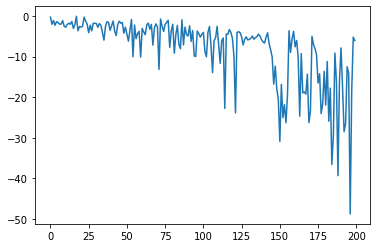

In [25]:
plt.plot(avg_per_x_element(all_losses))

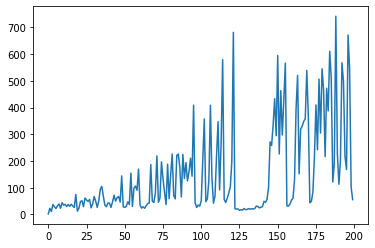

In [26]:
plt.plot(avg_per_x_element(all_rewards))

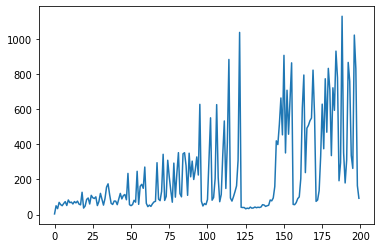

In [27]:
plt.plot(avg_per_x_element(all_timesteps))

In [36]:
channel = EngineConfigurationChannel()
env = UnityEnvironment(file_name='./Wave', seed=1, side_channels=[channel])
channel.set_configuration_parameters(time_scale = 3)
print("WAVE environment created.")

i = 0
env.reset()
while True:
    i += 1
    behavior_name = list(env.behavior_specs)[0]

    decision_steps, terminal_steps = env.get_steps(behavior_name)
    if (len(terminal_steps) > 0):
        break

    preds = model(torch.Tensor([preprocess_input(decision_steps)])).detach().numpy()
    print(f'TIMESTEP {i}, PREDS {preds}')

    action = np.argmax(preds)
    action_tuple = ActionTuple()
    action_tuple.add_discrete(np.array([[action]]))
    env.set_actions(behavior_name, action_tuple)
    env.step()

env.close()

WAVE environment created.
TIMESTEP 1, PREDS [[7.8272406e-06 9.9999213e-01]]
TIMESTEP 2, PREDS [[3.0457813e-05 9.9996948e-01]]
TIMESTEP 3, PREDS [[9.128057e-05 9.999087e-01]]
TIMESTEP 4, PREDS [[2.5229904e-04 9.9974769e-01]]
TIMESTEP 5, PREDS [[7.014287e-04 9.992986e-01]]
TIMESTEP 6, PREDS [[0.0018385 0.9981615]]
TIMESTEP 7, PREDS [[0.00446506 0.9955349 ]]
TIMESTEP 8, PREDS [[0.00421854 0.9957814 ]]
TIMESTEP 9, PREDS [[0.01630215 0.98369783]]
TIMESTEP 10, PREDS [[0.0762018 0.9237982]]
TIMESTEP 11, PREDS [[0.05605892 0.94394106]]
TIMESTEP 12, PREDS [[0.02298046 0.97701955]]
TIMESTEP 13, PREDS [[0.01716716 0.98283285]]
TIMESTEP 14, PREDS [[0.00984736 0.99015266]]
TIMESTEP 15, PREDS [[0.14650173 0.8534983 ]]
TIMESTEP 16, PREDS [[0.8626478  0.13735224]]
TIMESTEP 17, PREDS [[0.57200783 0.4279921 ]]
TIMESTEP 18, PREDS [[0.00692896 0.993071  ]]
TIMESTEP 19, PREDS [[0.06347886 0.9365211 ]]
TIMESTEP 20, PREDS [[0.3585609 0.6414391]]
TIMESTEP 21, PREDS [[0.70580786 0.29419222]]
TIMESTEP 22, PREDS

KeyboardInterrupt: 

In [1]:
env.close()

NameError: name 'env' is not defined